---
# 4. Simulation
---

Armed with the theory of the data generating process and the variance of the principal component regression coefficients, I examine how $\text{Var}(\hat{\beta_s})$, $\text{Var}(\hat{\beta_t})$ and $\text{Var}(\hat{Y_i})$ behave for different sample sizes. The results show that if the strategy from equation *(3.24)* is used to compute the $\text{Var}(\hat{\beta_s})$, the results for $\text{Var}(\hat{\beta_s})$ and $\text{Var}(\hat{\beta_t})$ do not differ.  

## 4.1 Simulate the whole Population
---

First I simulate the whole population. The full parameterization is given and justified in the appendix *A.10*. I have wrapped the whole data generating process in a function. The whole function can be found in the Github repository's folder ['R'](https://github.com/manuhuth/PCR-Parameter-Variance-Analysis/tree/master/R) in the file *DGP_function*. Since the data set is very large I decided to simulate it in advance and to upload the data to Github in three parts to meet the size requiremnst of GitHub. It is located in the folder ['SimData'](https://github.com/manuhuth/PCR-Parameter-Variance-Analysis/tree/master/SimData). The code I used to simulate is given in the next cell. If desired, also a smaller number of the population size yields reasonable reults. I have listed the inputs in the same order as they appear in Table 2 in the appendix. The function additionally allows to tune the optimization to obtain the logarithmic wage, which is not of greater concern for my purposes but facilitates implementations of further analysis.

In [131]:
#At the end set this on top of the notebook
options(repr.plot.width=8, repr.plot.height=4) #adjust plot size

setwd('C:/Users/Mhuth/Desktop/PCRPVA') #set your wordking directory to the name of the folder that your forked from GitHub
files <- c('PCA_PropVar', 'PCA', 'PCR_cv', 'PCR_predict', 'PCR', 'random_discreteVariables', 'random_VCV', 'DGP_function', 'plot_functions', 'coef_var_analysis', 'OLS_estimate') #define all files with functions to read from the foldr 'R'
for (i in 1:length(files)) { #loop to read all files
  source(paste('R/', files[i], '.R', sep = ''))
}

library(readxl) #Only necessary if own data is simulated
library(ggplot2) #plotting library
library(gridExtra) #extension to ggplot2

In [3]:
set.seed(123) #set random seed to ensure reproducibility
N <- 2300000 #set number of Observations. To test the Notebook, a small sample can be used. N = 1000 already yields reasonable results. However, this must be taken into account in the simulation study.

#simulate population. Since this takes long to execute, I have used a pre-simulated example that has been simulated using the subsequent code
#population <- dgp_model(var_ability = 1, max_age = 68, min_age = 33, n = N, prob_numbSiblings = 0.1, mean_numberSiblings = 1.692, var_numberSiblings = 2.89,
#                      mean_parent_educ = 13.342, variance_parent_educ = 21.215,
#                      gamma_ability = 2,  gamma_parent_educ = 2,
#                      breaks_test7_m = c(0, 0.141, 0.158, 0.185, 0.190, 0.212),  breaks_test11_m = c(0, 0.122,0.152, 0.157, 0.179, 0.199),
#                      breaks_test7_r =  c(0, 0.166, 0.179, 0.188, 0.187, 0.165),  breaks_test11_r = c(0, 0.132, 0.163, 0.163, 0.176, 0.176), test_cat = TRUE, var_err = 1,
#                      beta_min = c(0.03, 0.01, -0.06, -10, 0.01), mean_wage = 2.040, variance_wage = 1.5,  beta_max = c(0.06, 0.06, -0.03, 10, 10), tau = 0.5,  
#                      max_yearsSchooling = 29,  mean_schooling = 13.342, variance_schooling = 21.215, min_yearsSchooling = 0, q = 0.85,
#                      age_school_count = 4, probs_gap = c(0.59, 0.11,0.7,0.04, 0.03), gap_years = c(0,1,2,3,4))

#load simulated data in three parts, since otherwise it is too huge for GitHub
load('SimData/population1.Rda')
load('SimData/population2.Rda')
load('SimData/population3.Rda')
population <- as.data.frame(cbind(population1, population2, population3)) #make one data frame out of the three uploaded data frames

X <- population[c('test7_m', 'test11_m', 'test7_r', 'test11_r', 'parent_educ', 'schooling', 'numb_Siblings', 'working')] #define matrix of covariates for the regression
X <- cbind(X, X$working^2/100) #include squared working years divided by 100
colnames(X) <- c('test7_m', 'test11_m', 'test7_r', 'test11_r', 'parent_educ', 'schooling', 'numb_Siblings', 'working', 'working_squ') #set colnames of matrix of covariates

**TO-DO** histograms of unstandardized variables to appendix

Since I use normalized variables for PCA and PCR I only report the variance-covariance matrix of the normalized variables. I normalize to obtain a matrix of covariates that consists, as introduced in section *3*, of column vectors for which each cell of one vector come from the same distribution with mean zero. The variance covariance matrix is computed using N degree of freedomns, since the matrix consisting of the covariates is the whole population and not only a sample, such that the mean is known and has not to be estimated. The correlation matrix is obtained as in the appendix A.11, equation *(a.23)* by matrix multiplication of the variance covariance matrix and a matrix that has zero on the off-diagonals and one divided by the k-th standard deviation as k-th diagonal element

In [4]:
trans <- 'normalized' #indicate if data is normalized or standarized
if (trans == 'normalized') {
    X_stand <- scale(X, center = TRUE, scale = FALSE)  #normalization
} else {
    X_stand <- scale(X, center = TRUE, scale = TRUE)  #standardization
}

VCV <- t(X_stand)%*%X_stand/(N) #compute true variance covariance matrix. Since this is the wole population, I use N and not (N-1) in the denominator.
corr <-  diag(diag(VCV)^(-0.5)) %*% VCV %*% diag(diag(VCV)^(-0.5)) # H %*% \Sigma %*% H, as in equation a.23
colnames(corr) <-  c('test7_m', 'test11_m', 'test7_r', 'test11_r', 'parent_educ', 'schooling', 'numb_Siblings', 'working', 'working_squ')
rownames(corr) <-   c('test7_m', 'test11_m', 'test7_r', 'test11_r', 'parent_educ', 'schooling', 'numb_Siblings', 'working', 'working_squ')

It can be observed that, as desired in the data generating process, many variables, especially the test scores are highly correlated with the other variables. Working and its squred variable divided by 100 are close to be perfect multicollinear. This high multicollinearity would increase the variance of the OLS estimate.  

**Table X.X - Correlation of the Normalized Variables for the whole Population**

In [43]:
corr

,test7_m,test11_m,test7_r,test11_r,parent_educ,schooling,numb_Siblings,working,working_squ
test7_m,1.0000000,0.9136825,0.8401732,0.8031944,0.6189129,0.7199581,-0.16977309,-0.28242918,-0.27361457
test11_m,0.9136825,1.0000000,0.8053239,0.7977492,0.6217446,0.7197358,-0.16992051,-0.28203734,-0.27220329
test7_r,0.8401732,0.8053239,1.0000000,0.9097965,0.6242374,0.7254468,-0.17085071,-0.28432302,-0.27404970
test11_r,0.8031944,0.7977492,0.9097965,1.0000000,0.6220999,0.7202347,-0.16941423,-0.28228197,-0.27180700
parent_educ,0.6189129,0.6217446,0.6242374,0.6220999,1.0000000,0.9081710,-0.27200745,-0.35526466,-0.33629268
schooling,0.7199581,0.7197358,0.7254468,0.7202347,0.9081710,1.0000000,-0.24718518,-0.39131193,-0.37153867
numb_Siblings,-0.1697731,-0.1699205,-0.1708507,-0.1694142,-0.2720074,-0.2471852,1.00000000,0.09682776,0.09172515
working,-0.2824292,-0.2820373,-0.2843230,-0.2822820,-0.3552647,-0.3913119,0.09682776,1.00000000,0.98221477
working_squ,-0.2736146,-0.2722033,-0.2740497,-0.2718070,-0.3362927,-0.3715387,0.09172515,0.98221477,1.00000000


From the variance-covariance matrix we can compute the true matrix of eigenvectors $\pmb \phi$ and eigenvalues $\lambda$.

In [5]:
phi <- eigen(VCV)$vectors #compute eigenvectors of the variance covariance marix -> one solution from 2^9 = 512
lambda <- eigen(VCV)$values ##compute eigenvalues of the variance covariance marix -> unique

## 4.2 Convergence of Eigenvectors and Eigenvalues
---

### 4.2.1 A Simple 2-Dimensional Graphical Illustration
---

Since the eigenvectors are 8-Dimensional, they cannot be illustrated in a graph. Hence, I decided to start with a 2-dimensional case to give a first intuition how $\hat{\pmb \phi}$ converges to $\pmb \phi$ if he sample size increases. Moreover, since the direction is invariant to the choice of the representant of $[\phi]$ the implementation in the two dimensional case is straightforward. For this purpose I decided to use the variables *years of schooling* and *years of parent's education*. I chose these two variables since they have a high correlation of 0.9082 and had the same scale in the unstandardized set-up.   

In [15]:
X_2D <- X[ , c('parent_educ', 'schooling' )] #choose two variables
pca_2D <- PCA(X_2D, transform = trans) #do principal components analysis (written by me)
phi_2D <- pca_2D$phi #get matrix of eigenvectors (not unique)
plot_2D <- ggplot(as.data.frame(pca_2D$X_transformed[1:500,]), aes(parent_educ, schooling)) + geom_point() + #I only plot the first 500 points since otherwise the graph would be overloaded with points
                geom_abline(aes(intercept = 0, slope = phi_2D[1,1]/phi_2D[2,1], colour = 'first eigenvector'), size = 1) +
                labs(colour = '') +
                scale_colour_manual(values=c('green', 'red')) +
                geom_abline(aes(intercept = 0, slope = phi_2D[1,2]/phi_2D[2,2], colour = 'second eigenvector'), size = 1)

**Table X.X - Eigenvectors of the VCV Matrix of Years of Parent's Education and Years of Schooling**

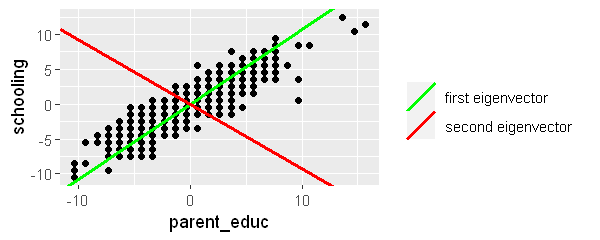

In [39]:
options(repr.plot.width=5, repr.plot.height=2) #adjust plot size
plot_2D #plo the graph

average eigenvectors make no sense -> just increase sample size. Convergence in Probability?

In [17]:
set.seed(1234) #set seet to ensure reporducibility
sample_size_2D <- c(20, 100, 500, 2000, 5000, 8000) #determine number of each sample size
plots_2D <- lapply(sample_size_2D, plot_2D_data, true_phi = phi_2D, true_X = X_2D, legend = TRUE, transform = trans) #use lapply function to plot graphs using the function plot_2D_data
legend <- cowplot::get_legend(plots_2D[[1]] + theme(legend.position = "bottom")) #cowplot::otherwise cowplot's ggplot theme is loaded
p_grid <- cowplot::plot_grid(plotlist = plots_2D, ncol = 3) #store plots in a grid

**Table X.X - Convergence of the Direction of Eigenvectors of Years of Parent's Education and Years of Schooling by Increasing the Sample Size**

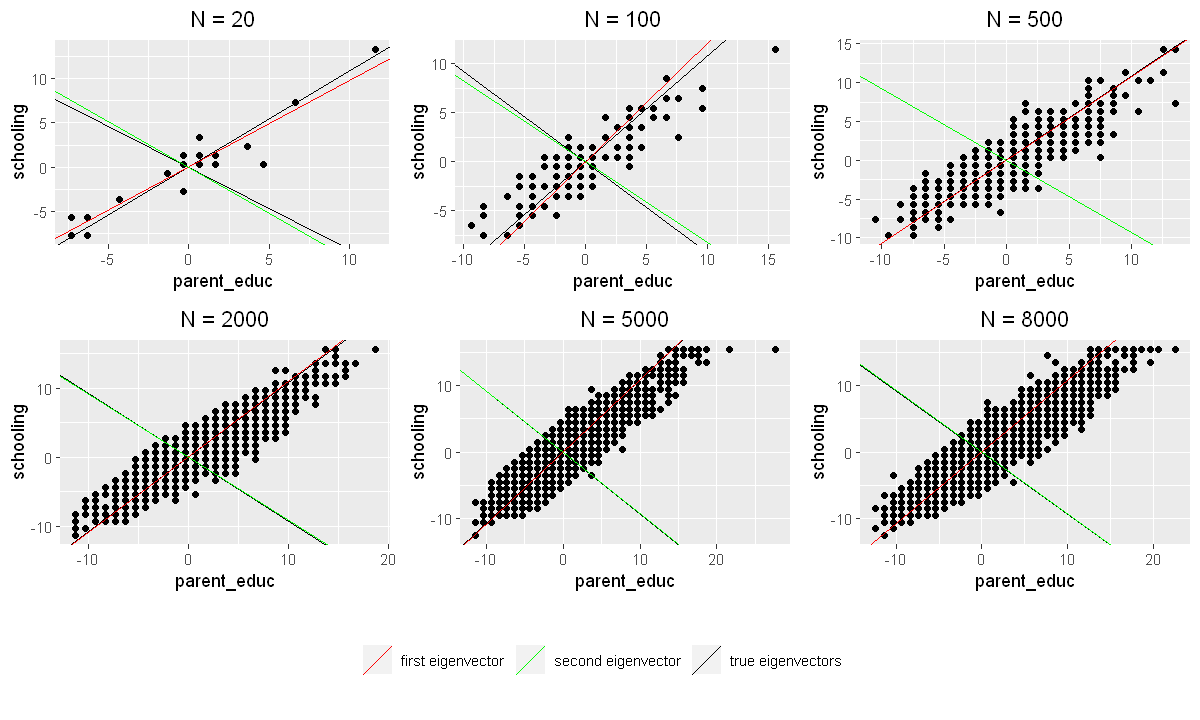

In [38]:
options(repr.plot.width=10, repr.plot.height=6) #adjust plot size
cowplot::plot_grid(p_grid, legend, ncol = 1, rel_heights = c(1, 0.2)) #plot plots from grid

## 4.3 Variance of the PCR Coefficients $\hat{\beta}$ in a Simulation Study
---

Subsequent I derive step by step a strategy to validate that $\widehat{\text{Var}(\hat{\beta_s})}^F_{n}$ and $\widehat{\text{Var}(\hat{\beta_t})}^F_{n}$ build reasonable quantities on how to decide if the variance of the principal component regression coefficients is larger if the true eigenvectors are unknown. 

   1. I compare $\widehat{\text{Var}(\hat{\beta_t})}^E_{n}$ and $\widehat{\text{Var}(\hat{\beta_t})}^F_{n}$ and derive that the empirical distribution of $\hat{\beta_t}$ yields the same variance estimates as using formula *(3.25)* to estimate the variance. 
   2. I compare $\widehat{\text{Var}(\hat{\beta_s})}^E_{n}$ and $\widehat{\text{Var}(\hat{\beta_s})}^F_{n}$ and observe that the variance estimates using the empirical distribution are for most parameters significantly higher and for some parameters equal than the estimates obtained by using formula *(3.24)*. 
   3. I compare $\widehat{\text{Var}(\hat{\beta_s})}^F_{n}$ and $\widehat{\text{Var}(\hat{\beta_t})}^F_{n}$ and find the there is no remarkable difference in the variances.
   
From 1. I conclude that if $\pmb \phi$ is unique, the strategy of deriving the variance in formulas *(3.24)* and *(3.25)* is valid and they can serve as suitable estimates of the true variances. From 1. and 2. I conclude that using $\widehat{\text{Var}(\hat{\beta_s})}^F_{n}$ and $\widehat{\text{Var}(\hat{\beta_t})}^F_{n}$ are the reasonable quantities to find whether the variances are different. In 3. it finally turns out that the variances are not different.

I have chosen sample sizes of $n = 50, 80, 100, 150, 200, 400, 600, 800, \dots, 5000$ to check the validity of the results in small and large samples. I chose $I$, the number of iterations (see formulas *(3.23)*,*(3.24)* and *(3.25)*), to be 400, which seemed large enogh to build the empirical distributions of the moments given in the stated formulas. To ensure robustness of my results I have simulated the variances 400 times for each sample size. For the purposes of this notebook, I have presimulated the results using the given seed *set.seed(12345)*. Since this took about 20 hours on a XXXXXXXXXXXXXXXXXXXXXXX computer, I recommend to decrease the number of samples for a fast implementation. 

By adjusting *line* the user can choose to either plot one particular result of the variances for each sample size (*line <- empirical*) or the mean of the variances for each sample size (*line <- mean*). I decided to plot the mean since this is the more robsut alternative taking all simulation results into account. By setting *type_CI* the user can decide to either plot the quantiles of the empirical distribution (*type_CI <- quantile*) or to plot the confidence intervals of the mean of the variances (*type_CI <- mean*). For the latter I assume an F-distribution of the standardized mean and therefore a normal distribution for $\widehat{\text{Var}(\hat{\beta_s})}^F_{n}$, $\widehat{\text{Var}(\hat{\beta_t})}^F_{n}$, $\widehat{\text{Var}(\hat{\beta_s})}^E_{n}$ and $\widehat{\text{Var}(\hat{\beta_t})}^E_{n}$. This seemed reasonable for $\widehat{\text{Var}(\hat{\beta_s})}^F_{n}$ and $\widehat{\text{Var}(\hat{\beta_t})}^F_{n}$ since they are computed as mean of i.i.d random variables and are thus approximately normal. For $\widehat{\text{Var}(\hat{\beta_s})}^F_{n}$ and $\widehat{\text{Var}(\hat{\beta_t})}^F_{n}$ this assumption might be wrong and the results therefore taken with caution. As extension, it would be desirable to find a more convncing strategy to compute the confidence intervals of the latter two. Due to the high computational costs ($400^3$ iterations in total, $400^2$ took 20 hours) and since the results are already straightforward, I did not compute the distribution of the means empirically. I decied to set *(type_CI <- 'quantile')* to reflect the distribution of the variances themselves.

In [108]:
sample_size <- c(50,80,100,150, seq(200, 5000, by = 200)) #decide on which sample sizes should be analyzed
set.seed(12345) #set seet to ensure reporducibility
population_Y <- cbind(population$logwage, X) #create matrix including the log-wages
M <- 9 # do it for all since it does not change the other
numb_it <- 400 #define number of iterations to compute the mean of the variances

#use the lapply function to create the variances for each coefficient and sample size. Since this takes around one day, I chose to pre-simulate the dataand load it.
#variance_analysis_results <- lapply(sample_size, coef_var_analysis, population = population_Y, true_phi = phi, M = M, transform = trans, iterations = numb_it, numb_iterations = numb_it) 

load("SimData/var.Rda") #load the stored results from the folder 'SimData'
confidence <- 0.95 #set level of confidence for the confidence bands
type_CI <- 'quantile' #either 'mean' or 'empirical'
line <- 'mean' #either 'mean' or 'empirical'
#use the lapply function to prepare all the plots. computes means and confidence intervals of the means of the variances for all coefficients and all sample sizes
variance_plots_data_CI <- lapply(c(1:M), prepare_variances_plots_CI, list_variances = variance_analysis_results,
                                            sample_size = sample_size, confidence = confidence, type_CI = type_CI, line = line, numb_it = numb_it)

The following cell allows the user to adjust the plots to her taste.

In [106]:
#set up plot to your taste
xlab <- 'Sample Size'
ylab <- 'Mean of Variance Estimate'
numb_columns <- 3 #number of columns per plot
col_prac_formula <- 'orange' #colour of the mean of the variance estimates of the estimates obtained by formula 3.24
col_prac <- 'blue' #colour of the mean of the variance estimates of the estimates obtained by formula 3.23 using stochastic phis
col_theo_formula <- 'green' #colour of the mean of the variance estimates of the estimates obtained by formula 3.25
col_theo <- 'red' #colour of the mean of the variance estimates of the estimates obtained by formula 3.24 using the true phi shown above

### 4.3.1 compare $\widehat{\text{Var}(\hat{\beta_t})}^E_{n}$ and $\widehat{\text{Var}(\hat{\beta_t})}^F_{n}$
---

I plot the variances and the quantiles, even though the latter cannot be seen since they are to small, as a function of the corresponding sample sizes. The means of the variances and the quantiles nearly coincide and thus I conclude that there is no remarkable difference in using $\widehat{\text{Var}(\hat{\beta_t})}^E_{n}$ or $\widehat{\text{Var}(\hat{\beta_t})}^F_{n}$. Hence, the formulas derived in *(3.24)* and *(3.25)* are reasonable estimates of the true variance and therefore it seems reasonable to use $\widehat{\text{Var}(\hat{\beta_t})}^F_{n}$ and $\widehat{\text{Var}(\hat{\beta_s})}^F_{n}$, if the variance derived from the empirical distribution $\widehat{\text{Var}(\hat{\beta_s})}^E_{n}$ is greater than $\widehat{\text{Var}(\hat{\beta_s})}^F_{n}$. I show that this is the case in the next subsection.

**Table X.X - Variance of $\hat{\beta_t}$ (True Phi) Computed with Formula 3.23 vs. Variance of $\hat{\beta_t}$ (True Phi) Computed with Formula 3.25**  

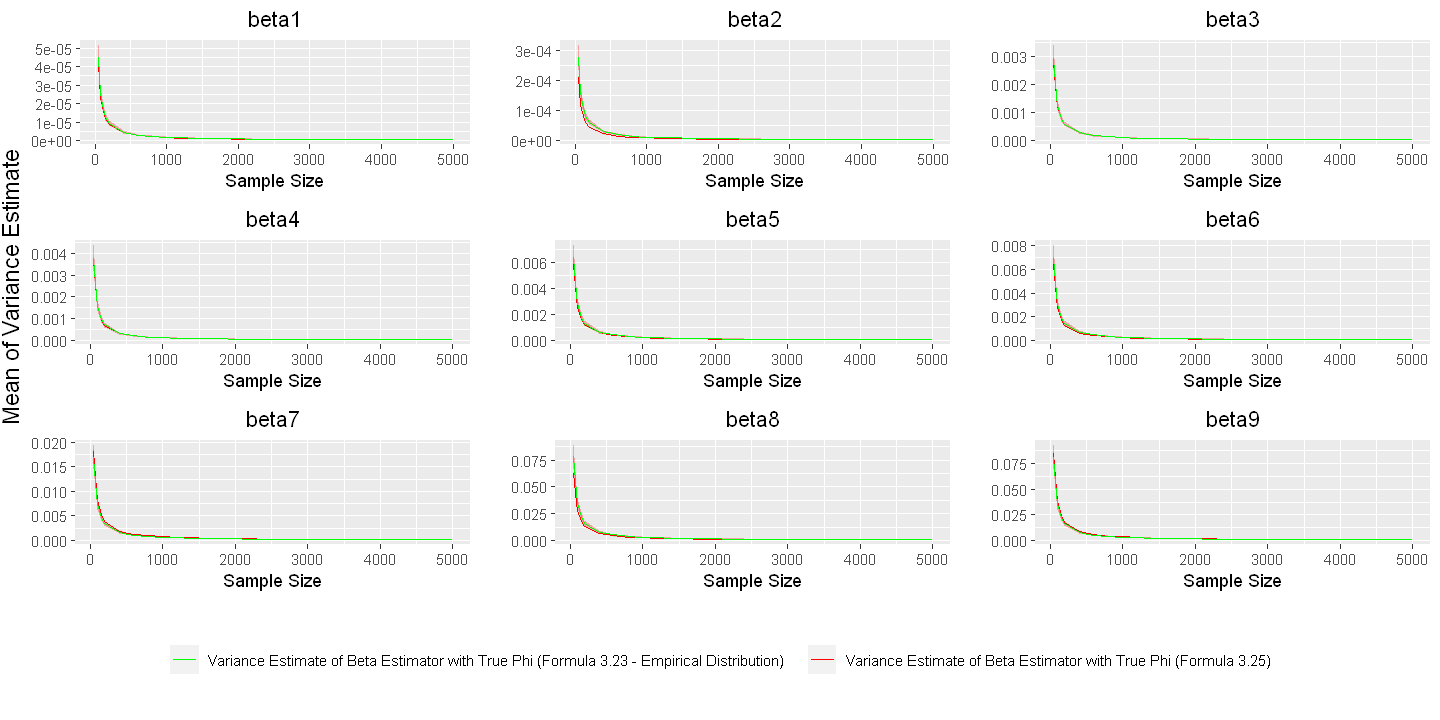

In [129]:
options(repr.plot.width=12, repr.plot.height=6) #adjust plot size
plots_variance_CI(variance_plots_data = variance_plots_data_CI, first_method = 'beta_theo_formula', second_method = 'beta_theo',
                  colour_1 = col_theo_formula, colour_2 = col_theo, xlab_string = xlab, ylab_string = ylab,
                  legend_df1 = 'Variance Estimate of Beta Estimator with True Phi (Formula 3.25)',
                  legend_df2 = 'Variance Estimate of Beta Estimator with True Phi (Formula 3.23 - Empirical Distribution)',
                  numb_columns = numb_columns, sample_size = sample_size, subtitle = 'beta')

### 4.3.2 Compare $\widehat{\text{Var}(\hat{\beta_s})}^E_{n}$ and $\widehat{\text{Var}(\hat{\beta_s})}^F_{n}$
---

Again, I plot the variances and the quantiles, as a function of the corresponding sample sizes. The means and the quantiles for $\widehat{\text{Var}(\hat{\beta_s})}^E_{n}$ are higher for most of the coefficients. For $\hat{\beta}_7$ and $\hat{\beta}_9$ the mean of the variances and the quantiles are basically the same and for $\hat{\beta}_2$ as well as $\hat{\beta}_5$ they converge to each other relatively fast. I suspect that *R*'s algorithm chooses one representation of $\hat{\pmb \phi}$ very reliable in those cases, whereas in the other cases, especially in small samples, the algorithm jumps between the two possible eigenvectors and therefore the variance is relatively high compared to using the non-eigenvector dependent formula. 

$\hat{\beta}_4$?

from here I conclude that empirical distribution leads to 'wrong' results. with 1. and 2. I conclude that I use the formulas

**Table X.X - Variance of $\hat{\beta_s}$ (Stochastic Phi) Computed with Formula 3.23 vs. Variance of $\hat{\beta_s}$ (Stochastic Phi) Computed with Formula 3.24**  

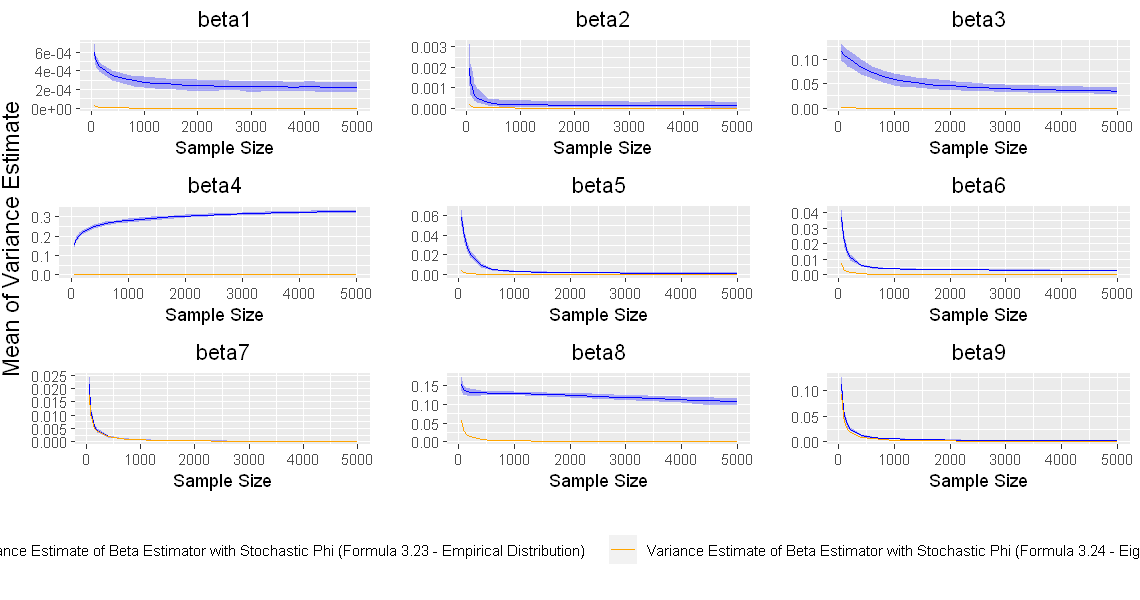

In [128]:
plots_variance_CI(variance_plots_data = variance_plots_data_CI, first_method = 'beta_prac', second_method = 'beta_prac_formula',
                  colour_1 = col_prac, colour_2 = col_prac_formula, xlab_string = xlab, ylab_string = ylab,
                  legend_df2 = 'Variance Estimate of Beta Estimator with Stochastic Phi (Formula 3.24 - Eigenvalues)',
                  legend_df1 = 'Variance Estimate of Beta Estimator with Stochastic Phi (Formula 3.23 - Empirical Distribution)',
                  numb_columns = numb_columns, sample_size = sample_size, subtitle = 'beta')

### 4.3.3 compare $\widehat{\text{Var}(\hat{\beta_t})}^F_{n}$ and $\widehat{\text{Var}(\hat{\beta_s})}^F_{n}$
---

formulas show that variances are basically the same and hence there is no increase in variance. thus, we would not expect increase in variancein Y hat

**Table X.X - Variance of $\hat{\beta_t}$ (True Phi) Computed with Formula 3.25 vs. Variance of $\hat{\beta_s}$ (Stochastic Phi) Computed with Formula 3.24**  

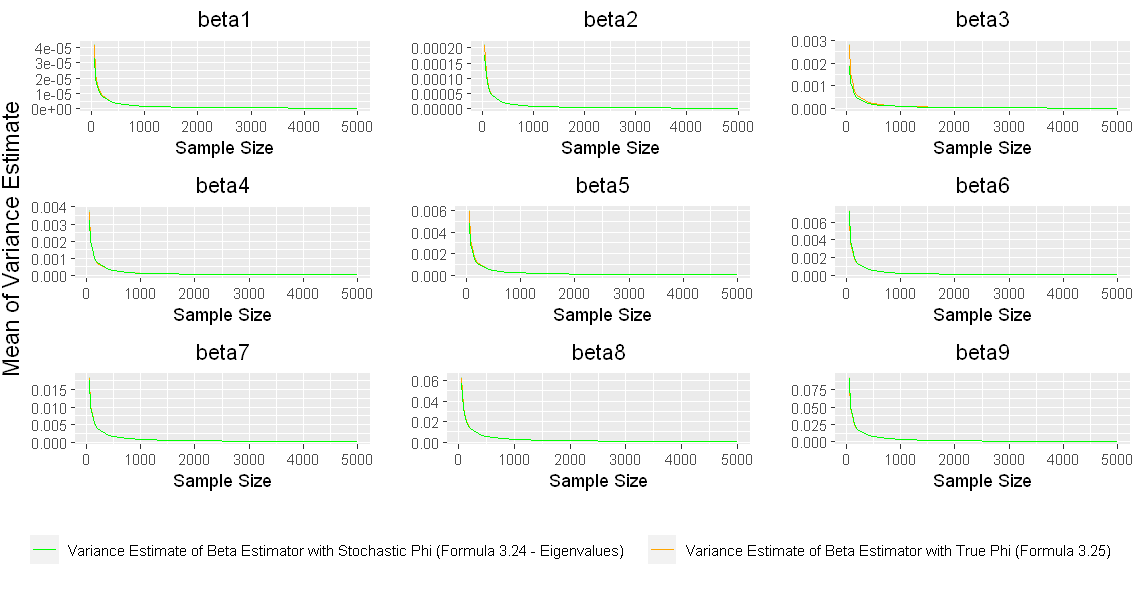

In [127]:
plots_variance_CI(variance_plots_data = variance_plots_data_CI, first_method = 'beta_theo_formula', second_method = 'beta_prac_formula',
                  colour_1 = col_theo_formula, colour_2 = col_prac_formula, xlab_string = xlab, ylab_string = ylab,
                  legend_df1 = 'Variance Estimate of Beta Estimator with True Phi (Formula 3.25)',
                  legend_df2 = 'Variance Estimate of Beta Estimator with Stochastic Phi (Formula 3.24 - Eigenvalues)',
                  numb_columns = numb_columns, sample_size = sample_size, subtitle = 'beta')

## 4.4 Variance of $\hat{Y}$
---

as expected from 4.3 no increase in variance

stochastic phi equals OLS

In [121]:
variances_Y_prac <- prepare_Y_variances(meth_interest = 'variances_Y_prac', list_variances = variance_analysis_results, confidence = confidence,
                                        type_CI = type_CI, line = line, numb_it = numb_it) #compute means and confidence intervals
variances_Y_theo <- prepare_Y_variances(meth_interest = 'variances_Y_theo', list_variances = variance_analysis_results, confidence = confidence,
                                        type_CI = type_CI, line = line, numb_it = numb_it) #compute means and confidence intervals
list_var_Y <- list(list('prac' = variances_Y_prac, 'theo' = variances_Y_theo)) #save all in one list that can be applied to the plots_variance_CI function

**Table X.X - Variance of $\hat{Y}_t$ (True Phi) vs. Variance of $\hat{Y}_s$ (Stochastic Phi)**  

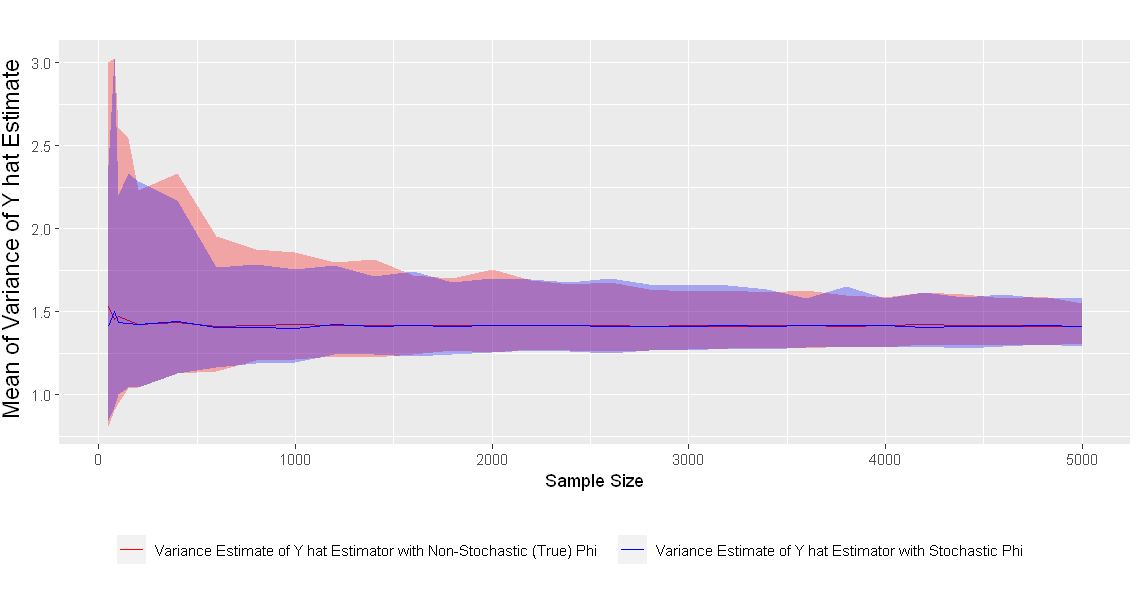

In [126]:
options(repr.plot.width=9.5, repr.plot.height=5) #adjust plot size
plots_variance_CI(variance_plots_data = list_var_Y, first_method = 'theo', second_method = 'prac',
                  colour_1 = 'red', colour_2 = 'blue', xlab_string = 'Sample Size', ylab_string = 'Mean of Variance of Y hat Estimate',
                  legend_df1 = 'Variance Estimate of Y hat Estimator with Non-Stochastic (True) Phi',
                  legend_df2 = 'Variance Estimate of Y hat Estimator with Stochastic Phi',
                  numb_columns = 1, sample_size = sample_size, subtitle = 'Y', make_subtitle = FALSE)